Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope, intercept]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 14 seconds.


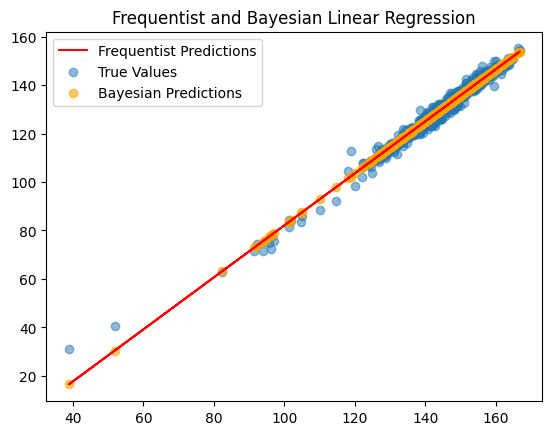

Frequentist Linear Regression
MSE: 4.813889496399354
MAE: 1.6477843172795923
Bayesian Linear Regression
MSE: 4.818579089684781
MAE: 1.6488293333831587


In [62]:
import pandas as pd
import pymc3 as pm
import arviz as az
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Load the data
data = pd.read_csv('Crab_molt.csv')
data = data.rename(columns={'pre molt size': 'presz', 'post molt size': 'postsz'})

# Drop NaN values
data = data.dropna()

# Use the full dataset
X_train_full = data[['postsz']]
y_train_full = data['presz']

# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_full_scaled = scaler_X.fit_transform(X_train_full)
y_train_full_scaled = scaler_y.fit_transform(y_train_full.values.reshape(-1, 1))

# Frequentist Linear Regression
frequentist_model = LinearRegression()
frequentist_model.fit(X_train_full_scaled, y_train_full_scaled)
y_pred_frequentist = frequentist_model.predict(X_train_full_scaled)

# Inverse transform the predicted values back to the original scale
y_pred_frequentist_original = scaler_y.inverse_transform(y_pred_frequentist)

# Bayesian Linear Regression with tighter priors and normal likelihood
with pm.Model() as improved_bayesian_model:
    # Priors for intercept and slope
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    slope = pm.Normal('slope', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Linear model
    mu = intercept + slope * X_train_full_scaled.flatten()
    
    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y_train_full_scaled.flatten())
    
    # Sample from the posterior
    trace_improved = pm.sample(3000, return_inferencedata=True)

# Posterior predictive checks
with improved_bayesian_model:
    ppc_improved = pm.sample_posterior_predictive(trace_improved, var_names=["likelihood"])

# Bayesian model predictions (mean values from posterior predictive)
predicted_means_improved = ppc_improved['likelihood'].mean(axis=0)

# Inverse transform the predicted values back to the original scale
predicted_means_improved_original = scaler_y.inverse_transform(predicted_means_improved.reshape(-1, 1))

# Plot the true values, Frequentist predictions, and Bayesian predictions on the same plot
plt.scatter(X_train_full, y_train_full, label="True Values", alpha=0.5)
plt.plot(X_train_full, y_pred_frequentist_original, color='red', label="Frequentist Predictions")
plt.scatter(X_train_full, predicted_means_improved_original, color='orange', label="Bayesian Predictions", alpha=0.6)
plt.legend()
plt.title('Frequentist and Bayesian Linear Regression')
plt.show()

# Print performance metrics for the frequentist model
print("Frequentist Linear Regression")
print(f"MSE: {mean_squared_error(y_train_full, y_pred_frequentist_original)}")
print(f"MAE: {mean_absolute_error(y_train_full, y_pred_frequentist_original)}")

# Print performance metrics for the Bayesian model
mse_improved = mean_squared_error(y_train_full, predicted_means_improved_original)
mae_improved = mean_absolute_error(y_train_full, predicted_means_improved_original)

print("Bayesian Linear Regression")
print(f"MSE: {mse_improved}")
print(f"MAE: {mae_improved}")

             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept -28.024  0.740 -29.412  -26.651      0.012    0.009    3724.0   
slope       1.092  0.005   1.082    1.102      0.000    0.000    3684.0   
sigma       2.016  0.073   1.877    2.152      0.001    0.001    5261.0   

           ess_tail  r_hat  
intercept    4310.0    1.0  
slope        4282.0    1.0  
sigma        4747.0    1.0  


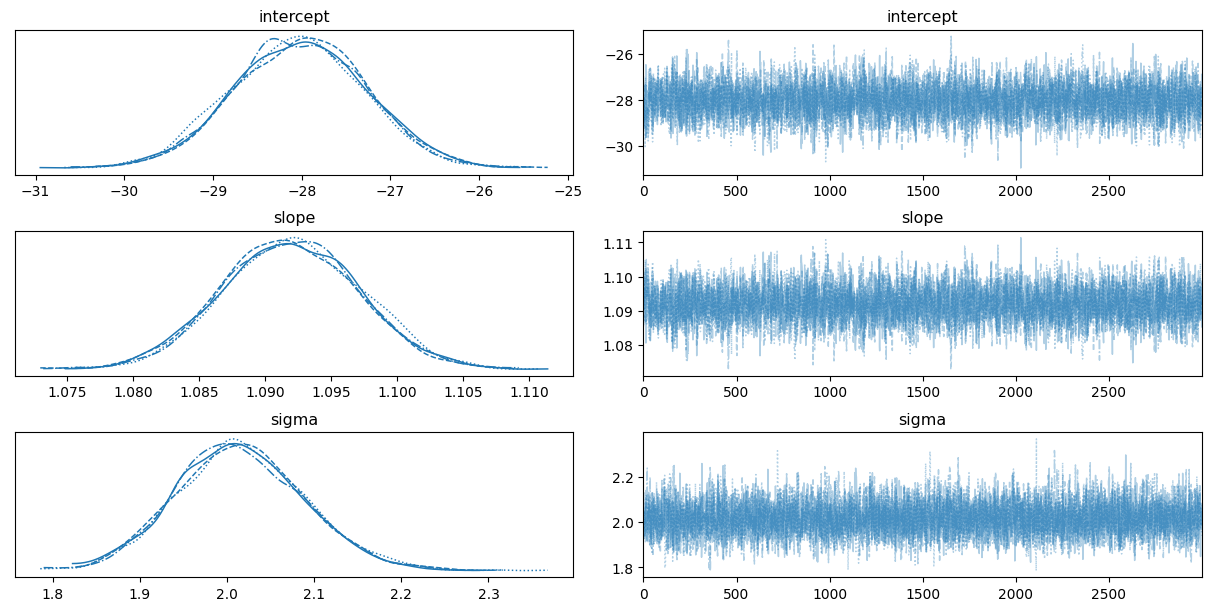

In [41]:
# Check convergence diagnostics using ArviZ
print(az.summary(trace_improved))  # Look for r_hat close to 1

# Plot trace plots for the parameters to visually inspect convergence
az.plot_trace(trace_improved)
plt.show()

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set a random seed for reproducibility
np.random.seed(42)

# Simulate 100 random data points with a linear relationship plus noise
X_sim = np.random.randn(100)  # Random normally distributed data for X
noise = np.random.normal(0, 1, 100)  # Gaussian noise
y_sim = 2.5 * X_sim + 1.0 + noise  # Linear relationship with noise

# Convert to a DataFrame
sim_data = pd.DataFrame({'X_sim': X_sim, 'y_sim': y_sim})

# Standardize the data (optional, but good practice)
scaler_X_sim = StandardScaler()
scaler_y_sim = StandardScaler()

X_sim_scaled = scaler_X_sim.fit_transform(sim_data[['X_sim']])
y_sim_scaled = scaler_y_sim.fit_transform(sim_data[['y_sim']].values.reshape(-1, 1))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope, intercept]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 14 seconds.


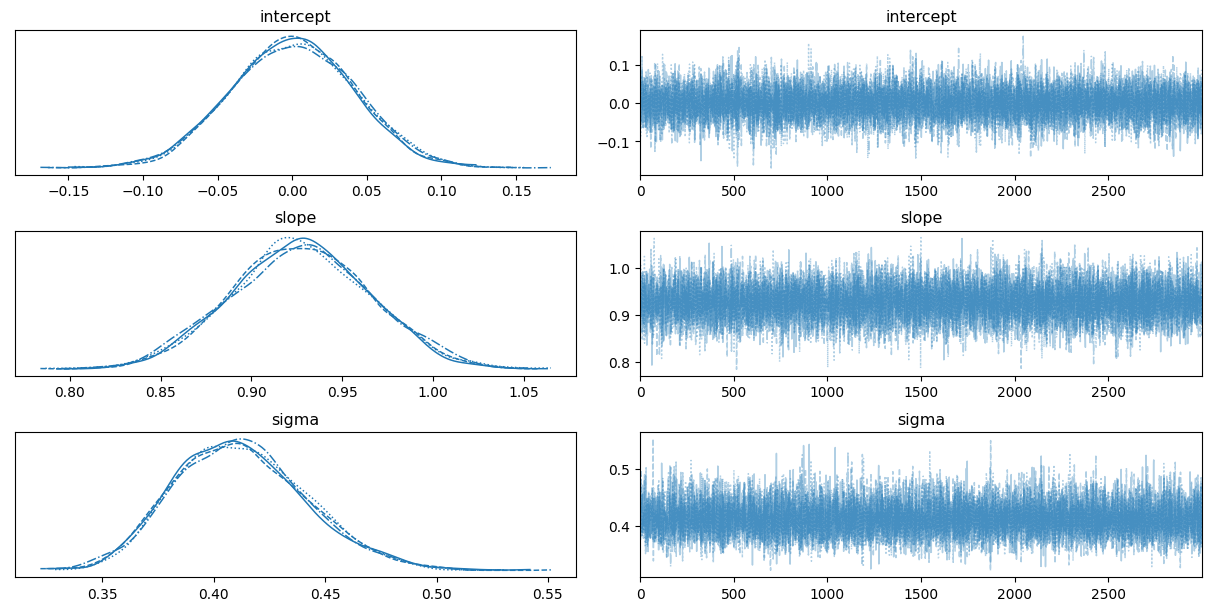

In [56]:
# Fit the Bayesian linear regression model
with pm.Model() as bayesian_sim_model:
    # Priors for intercept, slope, and noise (sigma)
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    slope = pm.Normal('slope', mu=1, sigma=0.1)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear model
    mu = intercept + slope * X_sim_scaled.flatten()

    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y_sim_scaled.flatten())

    # Posterior sampling
    trace_sim = pm.sample(3000, return_inferencedata=True)

# Posterior predictive checks
with bayesian_sim_model:
    ppc_sim = pm.sample_posterior_predictive(trace_sim, var_names=["likelihood"])

# Plot trace for diagnostics
az.plot_trace(trace_sim)
plt.show()


/Users/mccordmurray/bayesian/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


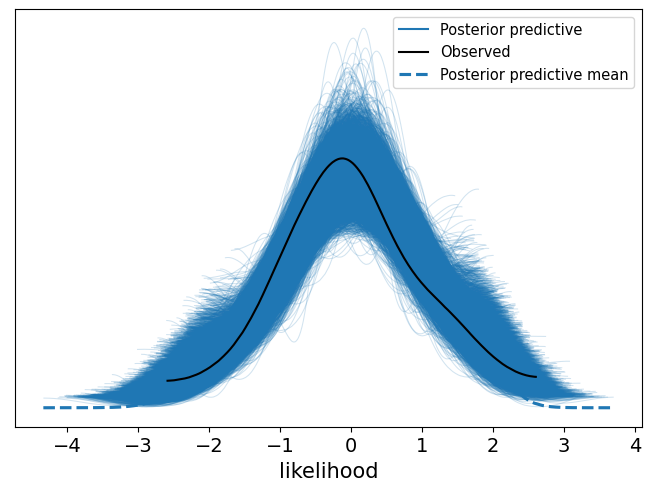

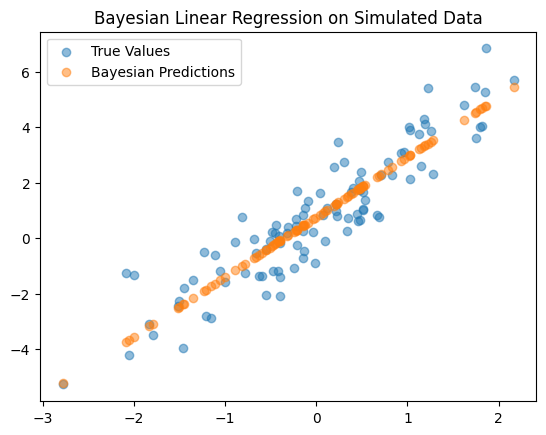

Bayesian Model MSE on Simulated Data: 0.8880822223958105
Bayesian Model MAE on Simulated Data: 0.7512791550272699


In [57]:
# Visualize posterior predictive distribution
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc_sim, model=bayesian_sim_model))
plt.show()

# Bayesian predictions (mean values of posterior predictive)
predicted_means_sim = ppc_sim['likelihood'].mean(axis=0)

# Inverse transform predictions and true values back to original scale
y_sim_pred_original = scaler_y_sim.inverse_transform(predicted_means_sim.reshape(-1, 1))
y_sim_true_original = scaler_y_sim.inverse_transform(y_sim_scaled)

# Plot the true values vs predictions
plt.scatter(X_sim_scaled, y_sim_true_original, label="True Values", alpha=0.5)
plt.scatter(X_sim_scaled, y_sim_pred_original, label="Bayesian Predictions", alpha=0.5)
plt.legend()
plt.title('Bayesian Linear Regression on Simulated Data')
plt.show()

# Calculate performance metrics
mse_sim = mean_squared_error(y_sim_true_original, y_sim_pred_original)
mae_sim = mean_absolute_error(y_sim_true_original, y_sim_pred_original)

print(f"Bayesian Model MSE on Simulated Data: {mse_sim}")
print(f"Bayesian Model MAE on Simulated Data: {mae_sim}")
